# THE FAKE-STATE-O-MATIC!!!

This does more or less what it says on the tin. A short program to generate some "fake state" data that can be used for testing and validation of redistricting programs.

In [1]:
# Nab the requisite imports
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import geometry


In [2]:
# Hold our geometry in a list
fake_state_geometry = []

# Generate geometry (in this case, a 5 x 10 grid of perfectly square precincts)
for i in range(0, 10):
    for j in range(0,5):
        p1 = geometry.Point(j, i)
        p2 = geometry.Point(j + 1, i)
        p3 = geometry.Point(j + 1, i + 1)
        p4 = geometry.Point(j, i + 1)
        point_list = [p1, p2, p3, p4]

        # Make our precinct geometry
        poly = geometry.Polygon([[p.x, p.y] for p in point_list])

        fake_state_geometry.append(poly)

fake_state_geometry = gpd.GeoSeries(fake_state_geometry)

In [3]:
# Populate our voter columns appropriately
rep_votes = []
dem_votes = []

for i in range(0, 50):
    if (i % 5) < 2:
        rep_votes.append(1)
        dem_votes.append(0)
    else: 
        rep_votes.append(0)
        dem_votes.append(1)

rep_votes = gpd.GeoSeries(rep_votes)
dem_votes = gpd.GeoSeries(dem_votes)
prec_name = ['prec_' + str(number) for number in range(0, 50)]

In [4]:
# Make the actual GeoDataFrame
fake_state_dict = {'loc_prec' : prec_name, 'rep_votes' : rep_votes, 'dem_votes' : dem_votes, 'geometry' : fake_state_geometry}
fake_state = gpd.GeoDataFrame(fake_state_dict)
fake_state['total_pop'] = fake_state['rep_votes'] + fake_state['dem_votes']

In [5]:
# Find neighboring precincts and add a column to the DataFrame containing them
for index, row in fake_state.iterrows():  
    neighbors = fake_state[fake_state.geometry.touches(row['geometry'])].loc_prec.tolist()
    if row.loc_prec in neighbors:
        neighbors = neighbors.remove(row.loc_prec)
    fake_state.at[index, "my_neighbors"] = ", ".join(neighbors)

,loc_prec,rep_votes,dem_votes,total_pop,my_neighbors,geometry
0,prec_0,1,0,1,"prec_1, prec_5, prec_6","POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1...."
1,prec_1,1,0,1,"prec_0, prec_2, prec_5, prec_6, prec_7","POLYGON ((1.00000 0.00000, 2.00000 0.00000, 2...."
2,prec_2,0,1,1,"prec_1, prec_3, prec_6, prec_7, prec_8","POLYGON ((2.00000 0.00000, 3.00000 0.00000, 3...."
3,prec_3,0,1,1,"prec_2, prec_4, prec_7, prec_8, prec_9","POLYGON ((3.00000 0.00000, 4.00000 0.00000, 4...."
4,prec_4,0,1,1,"prec_3, prec_8, prec_9","POLYGON ((4.00000 0.00000, 5.00000 0.00000, 5...."


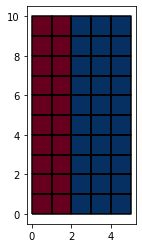

In [6]:
# Do some quick cleanup to keep things consistent
fake_state = fake_state[['loc_prec', 'rep_votes', 'dem_votes', 'total_pop', 'my_neighbors', 'geometry']]

# Produce some plots for quick verification
base = fake_state.plot(column = 'dem_votes', cmap = 'RdBu')
outlines = fake_state.boundary.plot(ax = base, color='k')

fake_state.head()

In [7]:
fake_state.to_file("../../Data/fake_states/washington_post/washington_post_fake_state.shp")